In [1]:
import yfinance as yf
from datetime import datetime


In [2]:
import pandas as pd

url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)"
}

sp500 = pd.read_html(url, storage_options=headers)[0]

tickers = sp500["Symbol"].tolist()

print(len(tickers))
print(tickers[:10])


503
['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']


In [3]:
import time
from typing import Dict, List, Tuple
from dateutil.relativedelta import relativedelta

import pandas as pd
import yfinance as yf

END   = datetime.now().strftime("%Y-%m-%d")
START = (datetime.now()-relativedelta(years=2)).strftime("%Y-%m-%d")

def normalize_tickers_for_yahoo(tickers: List[str]) -> List[str]:
    # Yahoo uses "-" instead of "." for class shares (e.g., BRK.B -> BRK-B)
    return [t.replace(".", "-").strip() for t in tickers if isinstance(t, str) and t.strip()]

def download_sp500_history(
    tickers: List[str],
    start: str = START,
    end: str = END,
    batch_size: int = 50,
    pause_s: float = 0.5,
    auto_adjust: bool = True,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Returns:
      - prices: MultiIndex columns: (Field, Ticker) with daily OHLCV (or adjusted OHLCV)
      - report: DataFrame of errors/missing-data info per ticker
    """
    tickers = normalize_tickers_for_yahoo(tickers)
    tickers = sorted(set(tickers))  # dedupe

    all_chunks = []
    report_rows: List[Dict] = []

    for i in range(0, len(tickers)+1, 50):
        chunk = yf.download(
            tickers=tickers[i:i+50],
            start=start,
            end=end,
            group_by="column",
            auto_adjust=auto_adjust,
            progress=False,
            threads=True,
        )
        all_chunks.append(chunk)
        time.sleep(0.5)

    if not all_chunks:
        prices = pd.DataFrame()
    else:
        prices = pd.concat(all_chunks, axis=1)


    return prices

prices = download_sp500_history(tickers, start=START, end=END)  # end is exclusive-ish
print("Downloaded shape:", prices.shape)



Downloaded shape: (501, 2515)


In [4]:
# prices['Close']
from datetime import datetime
prices_close = prices.Close.dropna(axis=1)
prices_close.to_csv(f"spy500_{END}.csv")

In [62]:

rolling_performance = prices_close.pct_change().rolling(250).mean()/prices_close.pct_change().rolling(250).std()
rank_rolling_performance = rolling_performance.rank(axis=1).dropna()

In [63]:
import numpy as np

median_rank = rank_rolling_performance.median(axis=1).iloc[-1]
rank_rolling_performance = rank_rolling_performance.where(rank_rolling_performance.ge(median_rank))

In [15]:
selection_of_stocks = rank_rolling_performance/rank_rolling_performance

In [16]:
corrs = prices_close.pct_change().ewm(125).corr()


In [66]:
corrs.index.levels[0]

DatetimeIndex(['2024-02-15', '2024-02-16', '2024-02-20', '2024-02-21',
               '2024-02-22', '2024-02-23', '2024-02-26', '2024-02-27',
               '2024-02-28', '2024-02-29',
               ...
               '2026-02-02', '2026-02-03', '2026-02-04', '2026-02-05',
               '2026-02-06', '2026-02-09', '2026-02-10', '2026-02-11',
               '2026-02-12', '2026-02-13'],
              dtype='datetime64[ns]', name='Date', length=501, freq=None)

In [67]:
corrs = corrs.sort_index()
last_corr = corrs.loc[corrs.index.get_level_values(0)[-1]]

In [77]:
stocks = list(rank_rolling_performance.iloc[-1].dropna().index)
curr_corr = last_corr.loc[stocks][stocks]

In [ ]:
# idx = corrs.index.levels[0][-1]
# stocks = list(selection_of_stocks.loc[idx].dropna(inplace=False).index)
# last_n_days = corrs.index.get_level_values(0).sort_values()[-125:]
# last_n_day_filtered = corrs.loc[last_n_days, stocks]

# df = last_n_day_filtered[last_n_day_filtered.index.get_level_values(1).isin(stocks)]

In [78]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt



def build_pmfg_from_corr(
    corr: pd.DataFrame,
    use_abs_corr: bool = False,
    stop_at_maximal: bool = True,
    verbose: bool = True,
) -> nx.Graph:
    """
    Build PMFG (Planar Maximally Filtered Graph) from an NxN correlation matrix.

    Algorithm (greedy):
      - sort all edges by descending corr (or |corr|)
      - add edges if planarity is preserved
      - stop at 3*(N-2) edges (maximal planar) if stop_at_maximal

    Returns:
      networkx.Graph with edge attrs:
        - corr: correlation
        - dist: Mantegna distance
        - weight: same as dist (convenient for nx algorithms)
    """
    tickers = list(corr.columns)
    n = len(tickers)

    corr_vals = corr.values.astype(float)
    dist = np.sqrt(2*(1 - corr))
    dist_vals = dist.values.astype(float)

    # Candidate edges (i<j)
    candidates = []
    for i in range(n):
        for j in range(i + 1, n):
            cij = float(np.clip(corr_vals[i, j], -1.0, 1.0))
            key = abs(cij) if use_abs_corr else cij
            candidates.append((key, i, j, cij, float(dist_vals[i, j])))

    candidates.sort(key=lambda x: x[0], reverse=True)

    target_edges = 3 * (n - 2) if stop_at_maximal else len(candidates)

    G = nx.Graph()
    G.add_nodes_from(tickers)

    added = 0
    checked = 0

    for _, i, j, cij, dij in candidates:
        if added >= target_edges:
            break

        u, v = tickers[i], tickers[j]
        if G.has_edge(u, v):
            continue

        # Tentatively add
        G.add_edge(u, v, corr=cij, dist=dij, weight=dij)

        # Check planarity
        is_planar, _ = nx.check_planarity(G, counterexample=False)
        checked += 1

        if not is_planar:
            G.remove_edge(u, v)
        else:
            added += 1
            if verbose and added % 200 == 0:
                print(f"[PMFG] added {added}/{target_edges} edges (checked {checked})")

    if verbose:
        print(f"[PMFG] done: nodes={G.number_of_nodes()} edges={G.number_of_edges()} target={target_edges}")
        ok, _ = nx.check_planarity(G, counterexample=False)
        print(f"[PMFG] planar={ok}")

    return G

# -------------------------
# Example usage
# -------------------------
# corr_shrunk: your NxN correlation DataFrame, index==columns==tickers, diag=1
pmfg = build_pmfg_from_corr(curr_corr, use_abs_corr=False, stop_at_maximal=True, verbose=True)


[PMFG] added 200/741 edges (checked 289)
[PMFG] added 400/741 edges (checked 889)
[PMFG] added 600/741 edges (checked 3461)
[PMFG] done: nodes=249 edges=741 target=741
[PMFG] planar=True


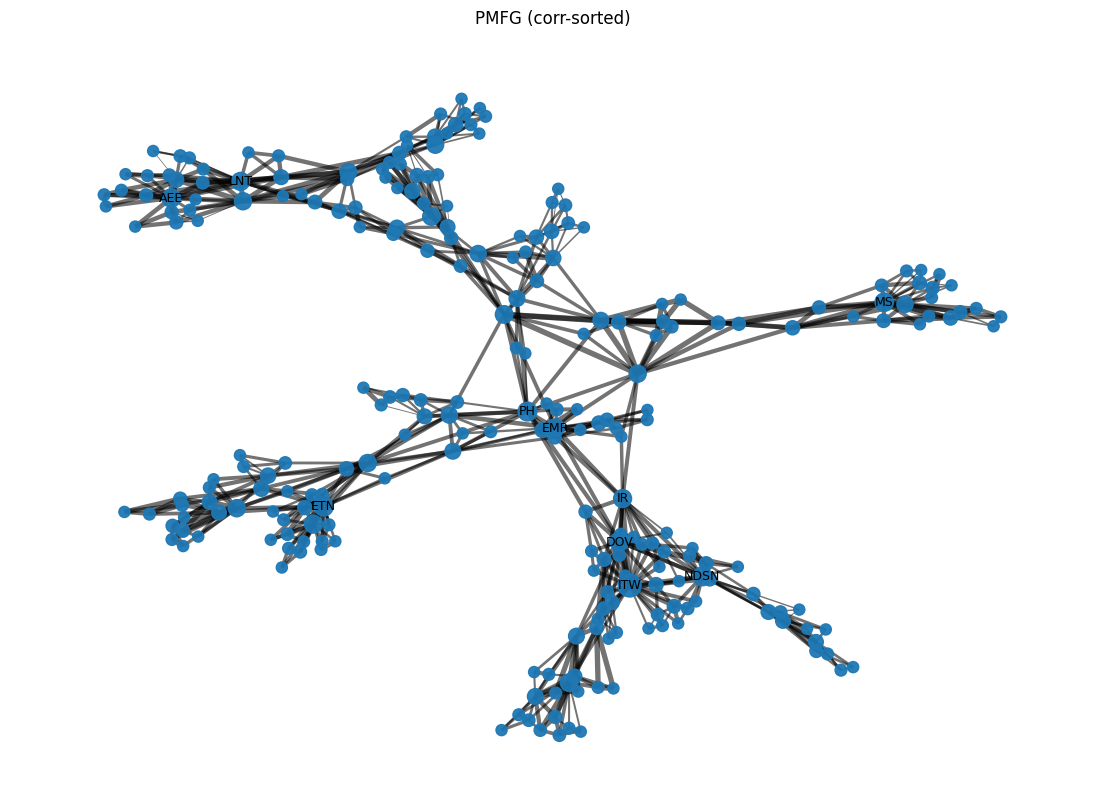

In [79]:

def visualize_pmfg(
    G: nx.Graph,
    title: str = "PMFG",
    layout: str = "spring",
    seed: int = 42,
    node_size: int = 40,
    label_top_k: int = 0,
):
    """
    Visualize PMFG with:
      - node size proportional to degree
      - edge width proportional to |corr|
      - optional labels for top_k highest-degree nodes
    """
    # Choose layout
    if layout == "spring":
        pos = nx.spring_layout(G, seed=seed, k=None)
    elif layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(G)
    else:
        raise ValueError("layout must be 'spring' or 'kamada_kawai'")

    degrees = dict(G.degree())
    deg_vals = np.array([degrees[n] for n in G.nodes()], dtype=float)

    # Node sizes: base + scaled degree
    sizes = (node_size + 8.0 * deg_vals).tolist()

    # Edge widths: scaled abs correlation
    corrs = np.array([abs(G[u][v].get("corr", 0.0)) for u, v in G.edges()], dtype=float)
    if len(corrs) > 0:
        widths = 0.5 + 4.0 * (corrs - corrs.min()) / (np.ptp(corrs) + 1e-12)
    else:
        widths = []

    plt.figure(figsize=(14, 10))
    nx.draw_networkx_edges(G, pos, width=widths, alpha=0.55)
    nx.draw_networkx_nodes(G, pos, node_size=sizes, alpha=0.95)


    if label_top_k and label_top_k > 0:
        top_nodes = sorted(degrees.items(), key=lambda kv: kv[1], reverse=True)[:label_top_k]
        labels = {n: n for n, _ in top_nodes}
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

    plt.title(title)
    plt.axis("off")
    plt.show()

visualize_pmfg(pmfg, title="PMFG (corr-sorted)", layout="spring", label_top_k=10)


In [142]:
deg_W = dict(nx.degree(pmfg, weight="dist"))
ecc_W = nx.eccentricity(pmfg, weight="dist")
graph_copy = pmfg.copy()
# only for eigen centrality because the measure is different
for u, v, data in graph_copy.edges(data=True):
    w = data["corr"]          # original correlation
    data["weight"] = w+1 if w!=0 else 0    

eigen_centrality_W = nx.eigenvector_centrality_numpy(graph_copy)
betweenness_centrality_W =  nx.betweenness_centrality(pmfg, weight="dist")
closeness_centrality_W =    nx.closeness_centrality(pmfg)


In [143]:
graph_copy = pmfg.copy()
for u, v, data in graph_copy.edges(data=True):
    w = data["dist"]          # original correlation
    data["dist"] = 1 if w!=0 else 0    

deg_UW = dict(nx.degree(graph_copy, weight="dist"))
ecc_UW = nx.eccentricity(graph_copy, weight="dist")

eigen_centrality_UW = nx.eigenvector_centrality_numpy(graph_copy, weight='dist')
betweenness_centrality_UW =  nx.betweenness_centrality(graph_copy, weight="dist")
closeness_centrality_UW =    nx.closeness_centrality(graph_copy)


In [144]:
deg_UW = pd.Series(deg_UW)
ecc_UW = pd.Series(ecc_UW)
eigen_centrality_UW = pd.Series(eigen_centrality_UW)
betweenness_centrality_UW = pd.Series(betweenness_centrality_UW)
closeness_centrality_UW = pd.Series(closeness_centrality_UW)

deg_W = pd.Series(deg_W)
ecc_W = pd.Series(ecc_W)
eigen_centrality_W = pd.Series(eigen_centrality_W)
betweenness_centrality_W = pd.Series(betweenness_centrality_W)
closeness_centrality_W = pd.Series(closeness_centrality_W)


In [145]:
N=len(deg_UW)
print(N)

249


In [146]:
X = (deg_W + deg_UW + betweenness_centrality_UW + betweenness_centrality_W - 4)/(4*(N-1))
Y = (ecc_UW + ecc_W + closeness_centrality_UW + closeness_centrality_W + eigen_centrality_UW + eigen_centrality_W - 6)/(6*(N-1))

<Axes: >

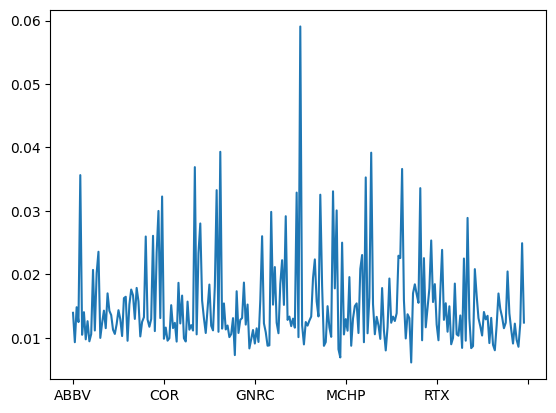

In [148]:
(X+Y).plot()